# infernce hsd

## import

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import argparse, os
import cv2
import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image
import datetime
from pytorch_lightning import seed_everything
import torchvision

from cldm.model import create_model, load_state_dict

## config

In [2]:
parser = argparse.ArgumentParser()

parser.add_argument(
    "--outdir",
    type=str,
    nargs="?",
    help="dir to write results to",
    default="inference_outputs"
)
parser.add_argument(
    "--ddim_steps",
    type=int,
    default=50,
    help="number of ddim sampling steps",
)
parser.add_argument(
    "--fixed_code",
    action='store_true',
    help="if enabled, uses the same starting code across samples ",
)
parser.add_argument(
    "--scale",
    type=float,
    default=3.0,
    help="unconditional guidance scale: eps = eps(x, empty) + scale * (eps(x, cond) - eps(x, empty))",
)
parser.add_argument(
    "--unconditional_guidance_id",
    type=bool,
    default=False,
    help="unconditional guidance scale only id (True) or id+CLIP (False)",
)
parser.add_argument(
    "--config",
    type=str,
    default="/home/wenchi/zxy/HSD/ControlNet/models/cldm_pve_v3.6.yaml",
    help="path to config which constructs model",
)
parser.add_argument(
    "--ckpt",
    type=str,
    default="/data1/wc_log/zxy/ckpt/v3.6-epoch=134-global_step=87209.0.ckpt",
    help="path to checkpoint of model",
)
parser.add_argument(
    "--arcface_ckpt",
    type=str,
    default="utils/arcface_pytorch/checkpoints/resnet18_110_onecard.pth",
    help="path to checkpoint of arcface model",
)
parser.add_argument(
    "--seed",
    type=int,
    default=42,
    help="the seed (for reproducible sampling)",
)
parser.add_argument(
    "--precision",
    type=str,
    help="evaluate at this precision",
    choices=["full", "autocast"],
    default="autocast"
)
parser.add_argument(
    "--source_image_path",
    type=str,
    default="/data0/wc_data/VFHQ/test/Clip+ka64cyDltpI+P0+C2+F2883-3062/00000066.png"
)
parser.add_argument(
    "--source_mask_path",
    type=str,
    default="/data0/wc_data/VFHQ/test/Clip+ka64cyDltpI+P0+C2+F2883-3062/mask_00000066.jpg"
)
parser.add_argument(
    "--target_image_path",
    type=str,
    default="/data0/wc_data/VFHQ/test/Clip+5FRSvDOczJ8+P0+C0+F302-415/00000001.png"
    # default="/data0/wc_data/VFHQ/test/Clip+ka64cyDltpI+P0+C2+F2883-3062/00000036.png"
)
parser.add_argument(
    "--target_mask_path",
    type=str,
    default="/data0/wc_data/VFHQ/test/Clip+5FRSvDOczJ8+P0+C0+F302-415/mask_00000001.jpg"
    # default="/data0/wc_data/VFHQ/test/Clip+ka64cyDltpI+P0+C2+F2883-3062/mask_00000036.jpg"
)
opt = parser.parse_args(args=[])


seed_everything(opt.seed)
config_path = opt.config
ckpt_path = opt.ckpt

Global seed set to 42


 ## load model

In [3]:
model = create_model(config_path).cpu()
model.load_state_dict(load_state_dict(ckpt_path, location='cpu'))
model = model.eval()
model = model.cuda()

No module 'xformers'. Proceeding without it.
ControlLDM_HSD: Running in eps-prediction mode
DiffusionWrapper has 859.54 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loaded model config from [/home/wenchi/zxy/HSD/ControlNet/models/cldm_pve_v3.6.yaml]
Loaded state_dict from [/data1/wc_log/zxy/ckpt/v3.6-epoch=134-global_step=87209.0.ckpt]


## prepare data

### prepare model

In [4]:
# get face detector
from face_alignment.detection.sfd.sfd_detector import SFDDetector
face_detector = SFDDetector(device='cuda')

# get ArcFace
from utils.arcface_pytorch.models.resnet import resnet_face18
arcface_model = resnet_face18(False)   # arcface get id information
state_dict = torch.load(opt.arcface_ckpt)
arcface_model.load_state_dict(state_dict)
arcface_model.cuda()
arcface_model.eval()

# get condition_Branch
from modules.ConditionBranch import Condition_Branch
condition_branch = Condition_Branch()

/home/wenchi/miniconda3/envs/diffusion/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/wenchi/miniconda3/envs/diffusion/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


creating the FLAME Decoder
trained model found. load /home/wenchi/zxy/HSD/ControlNet/utils/DECA/data/deca_model.tar


/home/wenchi/miniconda3/envs/diffusion/lib/python3.9/site-packages/pytorch3d/io/obj_io.py:548: UserWarning: Mtl file does not exist: /home/wenchi/zxy/HSD/ControlNet/utils/DECA/data/template.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


### process data

In [5]:
from DataPreprocess.getBBox import get_BBox
from DataPreprocess.detect3DMM import detect_3dmm
from DataPreprocess.getIdInformation import get_id_featurs

from dataset.HSD_dataset import smooth_expand_mask, mask_find_bbox, get_align_image, get_tensor_clip

source_image_path = opt.source_image_path
target_image_path = opt.target_image_path
source_mask_path = opt.source_mask_path
target_mask_path = opt.target_mask_path

imgs_numpy_list = [np.asarray(Image.open(imagepath).convert("RGB")) for imagepath in [source_image_path, target_image_path]]
imgs_numpy = np.asarray(imgs_numpy_list).transpose(0, 3, 1, 2) # (2, 3, H, W)
imgs_tensor = torch.from_numpy(imgs_numpy)
batch_size = 2

# get bbox
bboxlist = get_BBox(imgs_tensor, face_detector, batch_size=batch_size) # (2, 4)

# get id information
id_features = get_id_featurs(bboxlist, imgs_numpy, arcface_model, batch_size = batch_size) # (2, 512)

# get 3DMM dict
dict_3DMM = detect_3dmm(bboxlist, imgs_numpy, condition_branch.deca, batch_size = batch_size) # source, target

# get combined 3DMM dict
shape_code_new = dict_3DMM['shape'][0]
tex_code_new = dict_3DMM['tex'][0]
tforms_new = dict_3DMM['tforms'][1]
exp_code_new = dict_3DMM['exp'][1]
pose_code_new = dict_3DMM['pose'][1]
cam_code_new = dict_3DMM['cam'][1]
light_code_new = dict_3DMM['light'][1]

new_code_dict = {
    'tforms':tforms_new,
    'shape':shape_code_new,
    'tex':tex_code_new,
    'exp':exp_code_new,
    'pose':pose_code_new,
    'cam':cam_code_new,
    'light':light_code_new
}


# read images
source_image = np.asarray(Image.open(source_image_path).convert("RGB"))
target_image = np.asarray(Image.open(target_image_path).convert("RGB"))
source_mask_image = np.asarray(Image.open(source_mask_path))
target_mask_image = np.asarray(Image.open(target_mask_path))

# smooth and enlarge masks
source_mask_image = smooth_expand_mask(source_mask_image, ksize=(11, 11), sigmaX=11, sigmaY=11)
target_mask_image = smooth_expand_mask(target_mask_image, ksize=(55, 55), sigmaX=33, sigmaY=33)

# process source image
source_image = cv2.bitwise_and(source_image, source_image, mask = source_mask_image) # get masked
bbox = mask_find_bbox(source_mask_image)
source_image = get_align_image(bbox=bbox, img=source_image) # get align & resized source image, (224, 224, 3), numpy, 0~255
source_tensor = get_tensor_clip()(source_image.copy())

# get masked images (background)
bg_image = cv2.bitwise_and(target_image, target_image, mask = 255 - target_mask_image)

target_image = (target_image.astype(np.float32) / 127.5 - 1.0).transpose(2, 0, 1)  # Normalize target images to [-1, 1].
source_image = (source_image.astype(np.float32) / 127.5 - 1.0).transpose(2, 0, 1)  # Normalize source images to [-1, 1].
target_mask_image = np.expand_dims(target_mask_image.astype(np.float32) / 255.0, axis=0)

bg_image = bg_image.astype(np.float32) / 255.0
bg_image = torch.from_numpy(bg_image.transpose(2, 0, 1)) # (3, h, w)

rendered_images = condition_branch(new_code_dict) # (1, 3, h, w)

# all should be tensor and cuda
target_image = torch.from_numpy(target_image).unsqueeze(0).cuda()
target_mask_image = torch.from_numpy(target_mask_image).unsqueeze(0).cuda()
bg_image = bg_image.unsqueeze(0).cuda()
source_tensor = source_tensor.unsqueeze(0).cuda()
id_feature = torch.from_numpy(id_features[0]).unsqueeze(0).cuda()
source_image = torch.from_numpy(source_image).unsqueeze(0).cuda()
rendered_images = rendered_images.cuda()

batch = dict(target=target_image, 
             mask=target_mask_image, 
             background=bg_image, 
             source_global=source_tensor, 
             source_id=id_feature, 
             source_image=source_image, 
             hint=rendered_images)

### test predict x0

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

# get input
x_start, c = model.get_input(batch, model.first_stage_key, bs=1)

#### simply predict

tensor([100], device='cuda:0')


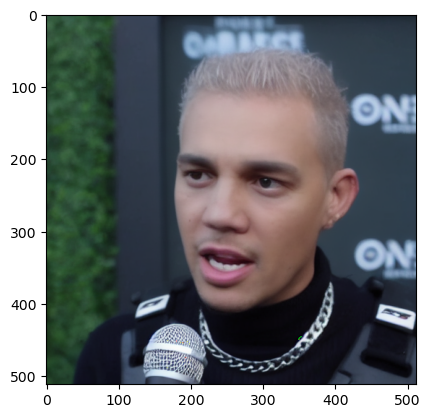

In [7]:
# t = torch.randint(0, model.num_timesteps, (x_start.shape[0],), device=model.device).long()
t = torch.randint(100, 101, (x_start.shape[0],), device=model.device).long()
print(t)

noise = torch.randn_like(x_start[:,:4,:,:])
x_noisy = model.q_sample(x_start=x_start[:,:4,:,:], t=t, noise=noise)
x_noisy = torch.cat((x_noisy, x_start[:,4:,:,:]),dim=1)

model_out = model.apply_model(x_noisy, t, c)

x_recon = model.predict_start_from_noise(x_noisy[:,:4,:,:], t, model_out) # predicted x0

recon_x0 = model.decode_first_stage(x_recon)
recon_x0 = recon_x0.detach().cpu().numpy()
recon_x0 = ((recon_x0.squeeze(0).transpose(1, 2, 0) + 1.0 ) * 127.5).astype(np.uint8)

plt.imshow(recon_x0)

#### ddim predict

In [8]:
def noise_like(shape, device, repeat=False):
    repeat_noise = lambda: torch.randn((1, *shape[1:]), device=device).repeat(shape[0], *((1,) * (len(shape) - 1)))
    noise = lambda: torch.randn(shape, device=device)
    return repeat_noise() if repeat else noise()

def make_ddim_timesteps(num_ddim_timesteps, num_ddpm_timesteps):
    c = num_ddpm_timesteps // num_ddim_timesteps
    ddim_timesteps = np.asarray(list(range(0, num_ddpm_timesteps, c)))
    steps_out = ddim_timesteps + 1
    
    return steps_out

def make_ddim_sampling_parameters(alphacums, ddim_timesteps, eta):
    # select alphas for computing the variance schedule
    alphas = alphacums[ddim_timesteps]
    alphas_prev = np.asarray([alphacums[0]] + alphacums[ddim_timesteps[:-1]].tolist())

    sigmas = eta * np.sqrt((1 - alphas_prev) / (1 - alphas) * (1 - alphas / alphas_prev))
    
    return sigmas, alphas, alphas_prev

In [9]:
from ldm.models.diffusion.ddim_hsd import DDIMSampler
ddim_sampler = DDIMSampler(model)

N = 1
c_cat, c = c["c_concat"][0][:N], c["c_crossattn"][0][:N]

samples, z_denoise_row = model.sample_log(cond={"c_concat": [c_cat], "c_crossattn": [c]},
                                                     batch_size=N, ddim=True,
                                                     ddim_steps=50, eta=0., rest=x_start[:N,4:,:,:],log_every_t = 5)



Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:05<00:00,  8.53it/s]


AttributeError: 'function' object has no attribute 'display'

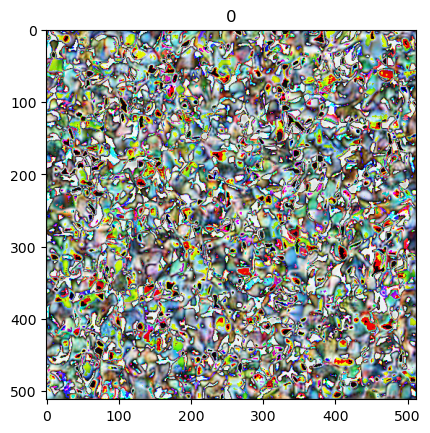

In [10]:
for i in range(len(z_denoise_row['pred_x0'])):
    z_denoise = z_denoise_row['pred_x0'][i]
    z_denoise = model.decode_first_stage(z_denoise)
    z_denoise = z_denoise.detach().cpu().numpy()
    z_denoise = ((z_denoise.squeeze(0).transpose(1, 2, 0) + 1.0 ) * 127.5).astype(np.uint8)
    plt.imshow(z_denoise)
    plt.title(i)
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [ ]:
%matplotlib inline
from IPython import display
# ddim set

## set input
N = 1
shape = (1, 4, 64, 64)
img = torch.randn(shape, device=model.device)
c_cat, c = c["c_concat"][0][:N], c["c_crossattn"][0][:N]
cond={"c_concat": [c_cat], "c_crossattn": [c]}

## set timestep
timesteps = make_ddim_timesteps(num_ddim_timesteps=50, num_ddpm_timesteps=1000)
time_range = np.flip(timesteps)
total_steps = timesteps.shape[0]

## set parameters
to_torch = lambda x: x.clone().detach().to(torch.float32).to(model.device)
alphas_cumprod = model.alphas_cumprod
ddim_eta=0.
ddim_sigmas, ddim_alphas, ddim_alphas_prev = make_ddim_sampling_parameters(alphacums=alphas_cumprod.cpu(), ddim_timesteps=timesteps, eta=ddim_eta)
ddim_sqrt_one_minus_alphas = np.sqrt(1. - ddim_alphas)


b, *_, device = *x_noisy.shape, x_noisy.device

from tqdm import tqdm
iterator = tqdm(time_range, desc='DDIM Sampler', total=total_steps)

for i, step in enumerate(time_range):
    index = total_steps - i - 1
    ts = torch.full((b,), step, device=device, dtype=torch.long)

    ## cat background & mask
    img = torch.cat((img, x_start[:,4:,:,:]), dim=1)

    ## run model
    e_t = model.apply_model(img, ts, cond)

    ## get parameters
    a_t = torch.full((b, 1, 1, 1), ddim_alphas[index], device=device)
    sigma_t = torch.full((b, 1, 1, 1), ddim_sigmas[index], device=device)
    a_prev = torch.full((b, 1, 1, 1), ddim_alphas_prev[index], device=device)
    sqrt_one_minus_at = torch.full((b, 1, 1, 1), ddim_sqrt_one_minus_alphas[index],device=device)

    ## cal x_prev
    pred_x0 = (img[:,:4,:,:] - sqrt_one_minus_at * e_t) / a_t.sqrt()
    dir_xt = (1. - a_prev - sigma_t**2).sqrt() * e_t
    noise = sigma_t * noise_like(dir_xt.shape, device, repeat = False)
    x_prev = a_prev.sqrt() * pred_x0 + dir_xt + noise

    img = x_prev 
    # img = pred_x0
    

    ## show image
    recon = model.decode_first_stage(img)
    recon = recon.detach().cpu().numpy()
    recon = ((recon.squeeze(0).transpose(1, 2, 0) + 1.0 ) * 127.5).astype(np.uint8)

    plt.imshow(recon)
    plt.title(step)
    display.display(plt.gcf())
    display.clear_output(wait=True)


## run model

In [ ]:
with torch.no_grad():
    images = model.log_images(batch, ddim_steps = opt.ddim_steps, unconditional_guidance_scale = opt.scale, unconditional_guidance_id = opt.unconditional_guidance_id)
    images['d_background'] = batch['background']

#### track memory

In [200]:
lr = 1e-5
params = list(model.control_model.parameters())

params += list(model.cond_stage_model.parameters())

opt = torch.optim.AdamW(params, lr=lr)

In [209]:
z = torch.rand(1, 9, 64, 64)
z.requires_grad = True
z_cuda = z.to(model.device)

In [221]:
a = model.first_stage_model.decode(z_cuda[:,:4,:,:])
print(a.grad_fn)

In [222]:
loss = (a + 1).mean() - a.mean()
print(loss)

tensor(1., device='cuda:0', grad_fn=<SubBackward0>)


In [212]:
print(z.grad)

None


In [217]:
loss.backward()

In [218]:
opt.step()

In [192]:
# del a
a.to('cpu')
torch.cuda.empty_cache()

In [208]:
del loss
torch.cuda.empty_cache()

## process image & make grid & calculate id loss

### import methods

In [ ]:
def cosine_distance(u: torch.Tensor, v: torch.Tensor, dim) -> torch.Tensor:
    # 计算两个张量之间的余弦距离
    return 1.0 - F.cosine_similarity(u, v, dim=dim)

def process_a_image(bbox, img, reshape_size = 128):
    ##  to process a img for arcface
    ##  img : numpy, uint8, 0~255, (3, h, w), RGB
    img = img.transpose(1, 2, 0) # 3, h, w -> h, w, 3
    h, w, _ = img.shape

    x1, y1, x2, y2 = bbox[0], bbox[1], bbox[2], bbox[3]

    center_point = [int((x1 + x2) / 2), int((y1 + y2) / 2)] ## recalculate the center point
    expand_size = int((y2 - y1) * 0.5) # expand_size -- half of the total crop size
    crop_size = expand_size * 2

    new_x1 = center_point[0] - expand_size
    new_x2 = center_point[0] + expand_size
    new_y1 = center_point[1] - expand_size
    new_y2 = center_point[1] + expand_size

    (crop_left, origin_left) = (0, new_x1) if new_x1 >= 0 else (-new_x1, 0)
    (crop_right, origin_right) = (crop_size, new_x2) if new_x2 <= w else (w-new_x1, w)
    (crop_top, origin_top) = (0, new_y1) if new_y1 >= 0 else (-new_y1, 0)
    (crop_bottom, origin_bottom) = (crop_size, new_y2) if new_y2 <= h else (h-new_y1, h)

    aligned_img = np.zeros((crop_size, crop_size, 3), dtype=np.uint8)
    aligned_img[crop_top:crop_bottom, crop_left:crop_right] = img[origin_top:origin_bottom, origin_left:origin_right]
    aligned_img = Image.fromarray(aligned_img)
    aligned_img = aligned_img.resize((reshape_size, reshape_size), Image.LANCZOS).convert('L')
    img = np.asarray(aligned_img)
    img = np.dstack((img, np.fliplr(img)))
    img = img.transpose((2, 0, 1))
    img = img[:, np.newaxis, :, :]
    img = img.astype(np.float32, copy=False)
    img -= 127.5
    img /= 127.5

    # 2 * 1 * 128 * 128

    return img

@torch.no_grad()
def get_id_feature(img_batch):
    ## this method get id feature of a image batch
    ## img_batch: tensor,  (B, 3, size, size), RGB, -1~1

    img_batch = (img_batch + 1.0) * 127.5

    output_batch = face_detector.detect_from_batch(img_batch)

    preprocessed_batch = []
    for i in range(len(output_batch)):
        BBox = output_batch[i][0].astype('int32')
        img = img_batch[i].numpy().astype('uint8')

        img = process_a_image(BBox, img)
        preprocessed_batch.append(img)
    preprocessed_batch = np.concatenate(preprocessed_batch, axis=0) # preprocessed_batch : (B*2, 1, 128, 128)
    preprocessed_batch = torch.from_numpy(preprocessed_batch)

    output_batch = arcface_model(preprocessed_batch.cuda())
    fe_1 = output_batch[::2]
    fe_2 = output_batch[1::2]
    feature = torch.cat((fe_1, fe_2), dim=1)

    return feature

@torch.no_grad()   
def get_id_loss(source_img, output_img):
    source_id_feature = get_id_feature(source_img)
    ouput_id_feature = get_id_feature(output_img) # (B, 1024)

    loss = cosine_distance(source_id_feature, ouput_id_feature, dim=1)
    return loss

def draw_id_loss(loss, grid):
    # grid: (H*B, W, 3), np.uint8, 0~255
    _, W, _ = grid.shape
    font = cv2.FONT_HERSHEY_SIMPLEX
    color = (255, 255, 255)
    thickness = 2
    fontScale = 1
    fix_up = 30

    grid = grid.copy()
    for i in range(loss.shape[0]):
        text = str(np.around(loss[i].numpy(), decimals=4))
        x = 0
        y = W * i + fix_up
        cv2.putText(grid, text, (x,y), font, fontScale=fontScale, color=color, thickness=thickness)
    
    return grid

def log_local(images, img_size = 512, id_loss_samples=None, id_loss_cfg=None):
    ## 获取当前时间秒数
    now = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    root = opt.outdir
    keys = sorted(images.keys())
    grid_list = []
    for k in keys:
        B = images[k].shape[0]
        grid = torchvision.utils.make_grid(images[k], nrow=1)
        grid = (grid + 1.0) / 2.0  # -1,1 -> 0,1; c,h,w
        grid = grid.transpose(0, 1).transpose(1, 2).squeeze(-1)
        grid = grid.numpy()
        grid = (grid * 255).astype(np.uint8) # H*B, W, 3
        if images[k].shape[2] != img_size:
            if B == 1:
                grid = np.asarray(Image.fromarray(grid).resize((img_size, img_size)))
            else:
                grid = np.asarray(Image.fromarray(grid).resize((img_size + 4, (img_size * B + 2 * (B + 1)))))

        # draw id loss
        if k == 'samples' and id_loss_samples is not None:
            grid = draw_id_loss(id_loss_samples, grid)

        if k == 'samples_cfg_scale' and id_loss_cfg is not None:
            grid = draw_id_loss(id_loss_cfg, grid)

        grid_list.append(grid)

    full_grid = np.concatenate(grid_list, axis=1)

    filename = "{}_scale[{}].png".format(now, opt.scale)
    path = os.path.join(root, filename)
    os.makedirs(os.path.split(path)[0], exist_ok=True)
    Image.fromarray(full_grid).save(path)

### log images

In [ ]:
# jupyter inline show
%matplotlib inline
import matplotlib.pyplot as plt

for k in images:
    images[k] = images[k].float()
    if isinstance(images[k], torch.Tensor):
        images[k] = images[k].detach().cpu()
        images[k] = torch.clamp(images[k], -1., 1.)

source_image = batch['source_image'].detach().cpu()

id_loss_samples = get_id_loss(source_image.clone(), images['samples']).detach().cpu()
id_loss_cfg = get_id_loss(source_image.clone(), images['samples_cfg_scale']).detach().cpu()

log_local(images, id_loss_samples = id_loss_samples, id_loss_cfg = id_loss_cfg)


In [20]:
import torch
a = torch.rand(1, 2)
print(a)
print(a.item())

tensor([[0.6813, 0.5874]])


ValueError: only one element tensors can be converted to Python scalars